In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import duckdb
import re
from datetime import datetime

In [5]:
tree = ET.parse('RSS.xml')
root = tree.getroot()

print(tree)
items = []
for item in root.findall('./channel/item'):
    title = item.find('title').text.strip() if item.find('title') is not None else ""
    link = item.find('link').text.strip() if item.find('link') is not None else ""
    pub_date_raw = item.find('pubDate').text.strip() if item.find('pubDate') is not None else ""
    
    # Convertir fecha de publicación
    try:
        pub_date = datetime.strptime(pub_date_raw, "%a, %d %b %Y %H:%M:%S %Z")
    except ValueError:
        pub_date = None

    filename = link.split('/')[-1]
    lower_link = link.lower()
    lower_filename = filename.lower()

    # --- Lógica de Extracción de Metadatos ---

    # A) Categoría Principal (estudios_completos, estudios_basicos, etc.)
    main_category = "Otros"
    if "estudios_completos" in lower_link:
        main_category = "Estudios Completos"
    elif "estudios_basicos" in lower_link:
        main_category = "Estudios Basicos"
    elif "estudios_rutas" in lower_link:
        main_category = "Estudios de Rutas"
    elif "zonificacion" in lower_link:
        main_category = "Zonificacion"

    # B) Tipo de Estudio (viajes, etapas, etc.)
    study_type = "Desconocido"
    if "viajes" in lower_filename:
        study_type = "Viajes"
    elif "etapas" in lower_filename:
        if "_c" in lower_filename or "carretera" in lower_link:
            study_type = "Etapas (Carretera)"
        else:
            study_type = "Etapas"
    elif "pernoctaciones" in lower_filename:
        study_type = "Pernoctaciones"
    elif "personas" in lower_filename:
        study_type = "Personas"
    elif "frecuencia" in lower_link or "frecuencia" in lower_filename:
        study_type = "Frecuencia"
    elif "calidad" in lower_link or "descartados" in lower_filename:
        study_type = "Calidad"
    elif "od_rutas" in lower_filename:
        study_type = "Matriz OD Rutas"
    elif "relaciones_tramos" in lower_filename:
        study_type = "Relaciones Tramos-Rutas"
    elif "tramos_info" in lower_filename:
        study_type = "Info Tramos OD"
    elif "zonificacion" in lower_link:
        study_type = "Geometria/Zonificacion"
    elif "agregados" in lower_filename:
        study_type = "Datos Agregados"

    # C) Zona (municipios, distritos, GAU)
    zone_type = "N/A" # Por defecto
    if "municipios" in lower_link or "municipios" in lower_filename:
        zone_type = "Municipios"
    elif "distritos" in lower_link or "distritos" in lower_filename:
        zone_type = "Distritos"
    elif "gau" in lower_link or "gau" in lower_filename:
        zone_type = "GAU"
    elif "rutas" in lower_link:
        zone_type = "Rutas"
    
    # D) Extracción de Fecha (YYYY, MM, DD) desde el nombre del archivo
    # Buscamos patrones como 20240101 (diario) o 202401 (mensual)
    year, month, day = None, None, None
    
    # Regex para YYYYMMDD
    date_match_daily = re.search(r'(\d{4})(\d{2})(\d{2})', filename)
    # Regex para YYYYMM (archivos mensuales o tar)
    date_match_monthly = re.search(r'(\d{4})(\d{2})', filename)
    
    if date_match_daily:
        year = int(date_match_daily.group(1))
        month = int(date_match_daily.group(2))
        day = int(date_match_daily.group(3))
    elif date_match_monthly:
        year = int(date_match_monthly.group(1))
        month = int(date_match_monthly.group(2))
        # day se queda como None para mensuales

    items.append({
        "main_category": main_category, # Nueva columna solicitada
        "study_type": study_type,
        "zone_type": zone_type,
        "year": year,
        "month": month,
        "day": day,
        "publication_date": pub_date,
        "filename": filename,
        "source_url": link
    })
df_catalog = pd.DataFrame(items)

In [6]:
con = duckdb.connect('movilidad_datalake.duckdb')
con.sql("CREATE SCHEMA IF NOT EXISTS bronze")
# Guardamos la tabla. Usamos CREATE OR REPLACE para facilitar re-ejecuciones.
con.sql("CREATE OR REPLACE TABLE bronze.catalog AS SELECT * FROM df_catalog")
con.sql("INSTALL spatial; LOAD spatial;")
con.sql("INSTALL httpfs; LOAD httpfs;")

CatalogException: Catalog Error: Existing object catalog is of type View, trying to replace with type Table

In [14]:
con.sql("SELECT * FROM parquet_scan('datalake\bronze\zonificacion\municiples.parquet')")

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
C:\Users\Jorge\AppData\Local\Temp\ipykernel_24620\2370717240.py:1: SyntaxWarning: invalid escape sequence '\z'
  con.sql("SELECT * FROM parquet_scan('datalake\bronze\zonificacion\municiples.parquet')")


IOException: IO Error: No files found that match the pattern "datalakeronze\zonificacion\municiples.parquet"

In [13]:
files_df = con.sql("""
    SELECT *
    FROM bronze.catalog 
    WHERE main_category = 'Estudios Basicos' AND study_type = 'Viajes'  AND zone_type = 'Distritos' AND year = '2023' AND month = '1'
""").df()
files_df

,main_category,study_type,zone_type,year,month,day,publication_date,filename,source_url
0,Estudios Basicos,Viajes,Distritos,2023.0,1.0,NaN,2023-02-08 12:06:57,202301_Viajes_distritos.tar,https://movilidad-opendata.mitma.es/estudios_b...
1,Estudios Basicos,Viajes,Distritos,2023.0,1.0,31.0,2023-02-08 10:47:01,20230131_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
2,Estudios Basicos,Viajes,Distritos,2023.0,1.0,30.0,2023-02-08 10:46:53,20230130_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
3,Estudios Basicos,Viajes,Distritos,2023.0,1.0,29.0,2023-02-08 10:46:40,20230129_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
4,Estudios Basicos,Viajes,Distritos,2023.0,1.0,28.0,2023-02-08 10:46:33,20230128_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
...,...,...,...,...,...,...,...,...,...
155,Estudios Basicos,Viajes,Distritos,2023.0,1.0,5.0,2023-02-08 10:43:33,20230105_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
156,Estudios Basicos,Viajes,Distritos,2023.0,1.0,4.0,2023-02-08 10:43:25,20230104_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
157,Estudios Basicos,Viajes,Distritos,2023.0,1.0,3.0,2023-02-08 10:43:17,20230103_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...
158,Estudios Basicos,Viajes,Distritos,2023.0,1.0,2.0,2023-02-08 10:43:10,20230102_Viajes_distritos.csv.gz,https://movilidad-opendata.mitma.es/estudios_b...


In [15]:
import os
os.makedirs('datalake/bronze/catalog', exist_ok=True)
con = duckdb.connect('movilidad_datalake.duckdb')
con.sql("""
    COPY bronze.catalog 
    TO 'datalake/bronze/catalog/catalog_data.parquet' 
    (FORMAT PARQUET)
""")

In [16]:
files_df = con.sql("""
    SELECT source_url 
    FROM bronze.catalog 
    WHERE main_category = 'Estudios Basicos'
      AND study_type = 'Viajes'
      AND zone_type = 'Distritos'
      AND year = 2023
      AND month = 1
      AND filename LIKE '%.csv.gz' 
""").df()
files_df

,source_url
0,https://movilidad-opendata.mitma.es/estudios_b...
1,https://movilidad-opendata.mitma.es/estudios_b...
2,https://movilidad-opendata.mitma.es/estudios_b...
3,https://movilidad-opendata.mitma.es/estudios_b...
4,https://movilidad-opendata.mitma.es/estudios_b...
...,...
212,https://movilidad-opendata.mitma.es/estudios_b...
213,https://movilidad-opendata.mitma.es/estudios_b...
214,https://movilidad-opendata.mitma.es/estudios_b...
215,https://movilidad-opendata.mitma.es/estudios_b...


In [ ]:
urls = files_df["source_url"].tolist()

In [ ]:
len(urls)

31

In [ ]:
con.sql(f"""
    CREATE OR REPLACE TABLE bronze.viajes_2023_01 AS
    SELECT *,

        FROM read_csv({urls[:10]}, filename=true)
""")

In [ ]:
print(con.sql("DESCRIBE bronze.viajes_2023_01"))


┌─────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│       column_name       │ column_type │  null   │   key   │ default │  extra  │
│         varchar         │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ fecha                   │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ periodo                 │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ origen                  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ destino                 │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ distancia               │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ actividad_origen        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ actividad_destino       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ estudio_origen_posible  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ estudio_destin

In [ ]:
def cargar_viajes_por_criterio(con, year, month, zone_type):
    """
    Args:
        con: Conexión a DuckDB
        year (int): Año a cargar (ej. 2023)
        month (int): Mes a cargar (ej. 1)
        zone_type (str): Nivel de zona ('Municipios', 'Distritos', 'GAU')
    """
    
    # 1. Consultar el Catálogo para obtener las URLs
    # Buscamos ficheros diarios (.csv.gz) de Estudios Básicos -> Viajes
    files_df = con.sql(f"""
        SELECT source_url 
        FROM bronze.catalog 
        WHERE year = {year}
          AND month = {month}
          AND zone_type = '{zone_type}'
          AND main_category = 'Estudios Basicos'
          AND study_type = 'Viajes'
          AND filename LIKE '%.csv.gz'
    """).df()
    
    urls = files_df['source_url'].tolist()
    
    if not urls:
        print(f" No se encontraron archivos en el catálogo para este criterio.")
        return

    # 2. Definir columnas variables según el tipo de zona
    # (El MITMA a veces cambia nombres, esto lo estandariza)
    if zone_type == 'Municipios':
        col_origen = "origen"  # A veces vienen como id_origen
        col_destino = "destino"
    else:
        col_origen = "origen"     # En distritos suele ser origen
        col_destino = "destino"

    # 3. Ejecutar la Ingestión (INSERT con transformación al vuelo)
    # Usamos try/except para capturar errores de red o formato
    try:
        # Nota: Usamos COALESCE o alias en el SELECT para mapear las columnas del CSV 
        # a las de nuestra tabla destino (origen, destino).
        # La opción filename=True en read_csv nos da la URL de origen automáticamente.

        query = f"""
            INSERT INTO bronze.od_trips
            SELECT 
                -- 1. Datos del CSV (Mapeo de columnas)
                fecha as date,
                periodo as period,
                CAST({col_origen} AS VARCHAR) as id_origin,
                CAST({col_destino} AS VARCHAR) as id_destination ,
                distancia as distance,
                actividad_origen as activity_origin,
                actividad_destino as activity_destination,
                estudio_origen_posible as study_origin_pos,
                estudio_destino_posible as study_destination_pos,
                residencia as residence,
                renta as rent,
                edad as age,
                sexo as sex,
                viajes as n_trips,
                viajes_km as trips_total_length_km,
                -- 2. Metadatos (Tus columnas personalizadas)
                '{zone_type}' as zone_type,  -- Valor fijo pasado por parámetro
                filename as source_url,      -- Columna mágica generada por read_csv(..., filename=True)
                current_timestamp as ingestion_date

            FROM read_csv(
                {urls[:2]}, 
                delim='|', 
                header=True, 
                filename=True,       -- Fundamental para llenar source_url
                union_by_name=True,  -- Robustez si cambia el orden de columnas
                null_padding=True,
                ignore_errors=True
            )
        """
        
        con.sql(query)
        print(f" Éxito: Datos cargados en bronze.od_trips.")
        
    except Exception as e:
        print(f" Error durante la ingestión: {e}")

In [ ]:
con.sql("DROP TABLE bronze.od_trips")

In [ ]:
con.sql("""
    CREATE OR REPLACE TABLE bronze.od_trips (
        date VARCHAR,
        period VARCHAR,
        id_origin VARCHAR,
        id_destination VARCHAR,
        distance VARCHAR,
        activity_origin VARCHAR,
        activity_destination VARCHAR,
        study_origin_pos VARCHAR,
        study_destination_pos VARCHAR,
        residence VARCHAR,
        rent VARCHAR,
        age VARCHAR,
        sex VARCHAR,
        n_trips VARCHAR,
        trips_total_length_km VARCHAR,
        
        zone_type VARCHAR,
        source_url VARCHAR,
        ingestion_date TIMESTAMP
    );
""")

In [ ]:
cargar_viajes_por_criterio(con, 2023, 1, "Distritos")

🚀 Éxito: Datos cargados en bronze.raw_viajes.


In [ ]:
con.sql("""
    -- 1. Convertir la columna usando strptime
    ALTER TABLE bronze.od_trips
    ALTER COLUMN date SET DATA TYPE DATE 
    USING strptime(date, '%Y%m%d')::DATE;
""")

In [ ]:
df = con.sql("""
    SELECT *
    FROM bronze.od_trips WHERE zone_type LIKE 'Distritos'
    LIMIT 100

""").df()
df

,date,period,id_origin,id_destination,distance,activity_origin,activity_destination,study_origin_pos,study_destination_pos,residence,rent,age,sex,n_trips,trips_total_length_km,zone_type,source_url,ingestion_date
0,2023-01-31,00,01001,01001,2-10,frecuente,casa,no,no,01,10-15,NA,NA,5.739,23.034,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
1,2023-01-31,00,01001,01001,2-10,frecuente,trabajo_estudio,no,no,01,>15,45-65,hombre,2.807,10.502,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
2,2023-01-31,05,01001,01001,2-10,frecuente,casa,no,no,01,10-15,NA,NA,2.468,9.65,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
3,2023-01-31,05,01001,01001,2-10,trabajo_estudio,frecuente,no,no,01,>15,45-65,hombre,2.807,10.502,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
4,2023-01-31,08,01001,01001,2-10,casa,no_frecuente,no,no,01,10-15,NA,NA,3.072,11.34,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-01-31,15,01001,01009_AM,0.5-2,casa,frecuente,no,no,01,10-15,NA,NA,2.667,3.033,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
96,2023-01-31,15,01001,01009_AM,0.5-2,trabajo_estudio,casa,no,no,01,>15,NA,NA,1.5,1.804,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
97,2023-01-31,15,01001,01009_AM,10-50,frecuente,casa,no,no,01,>15,NA,NA,3.097,39.067,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244
98,2023-01-31,15,01001,01009_AM,2-10,casa,frecuente,no,no,01,10-15,NA,NA,6.696,37.901,Distritos,https://movilidad-opendata.mitma.es/estudios_b...,2025-11-25 17:29:18.482244


In [ ]:
con.sql("""
    COPY (
        SELECT 
            *,
            -- 1. Añadimos la columna SOURCE explícita (Requisito MITMA/INE)
            'MITMA' as source,
            
            -- 2. Generamos columnas derivadas para el particionado de FECHA
            YEAR(date) as part_year,
            MONTH(date) as part_month
        FROM bronze.od_trips
        )
        TO 'datalake/bronze/viajes' 
    (
        FORMAT PARQUET, 
        -- 3. Particionamos por ZONA, FUENTE y FECHA (Tal cual pide el enunciado)
        PARTITION_BY (zone_type, source, part_year, part_month), 
        COMPRESSION 'ZSTD', 
        OVERWRITE_OR_IGNORE,
        FILENAME_PATTERN 'data_{uuid}'
    )
""")


In [ ]:
def cargar_info_zona(con,zone_type):
    # zone_type = 'municipios','distritos','gaus'
    #Find in catalog zone type files
    file_info = con.sql(f"""
    SELECT source_url, filename 
    FROM bronze.catalog 
    WHERE (main_category = 'Zonificacion' OR main_category = 'Otros')
      AND (filename ILIKE '%{zone_type}%') 
      AND (filename ILIKE '%.shp' OR filename ILIKE '%.shx' OR filename ILIKE '%.dbf' OR filename ILIKE '%.prj' OR filename ILIKE '%.csv')
        
        """).df()
    
    #temp dowload data
    urls = file_info["source_url"]
    os.makedirs(f"temp_downloads/{zone_type}", exist_ok=True)
    for key, url in urls.items():
        filename = url.split('/')[-1]
        path = f"temp_downloads/{zone_type}/{filename}"
        # Descargamos solo si no existe para ahorrar tiempo
        if not os.path.exists(path):
            print(f"Descargando {filename}...")
            r = requests.get(url)
            with open(path, 'wb') as f:
                f.write(r.content)

    zone_dic = {"municipios":"municiples","distritos":"districts","gaus":"GAUS"}

    #Create bronze raw tables
    con.sql(f"CREATE OR REPLACE TABLE bronze.{zone_dic[zone_type]}_raw_geo AS SELECT * FROM st_read('temp_downloads/{zone_type}/zonificacion_{zone_type}.shp')")

    # B) Cargar Nombres (CSV)
    con.sql(f"""
        CREATE OR REPLACE TABLE  bronze.{zone_dic[zone_type]}_raw_names AS 
        SELECT * FROM read_csv('temp_downloads/{zone_type}/nombres_{zone_type}.csv', delim='|', header=True, auto_detect=True)
    """)
    #Join tables into zonetype info table
    con.sql(f"""
            CREATE OR REPLACE TABLE bronze.{zone_dic[zone_type]}_info AS
            SELECT 
                -- IDs y Nombres
                t1.ID as id_{zone_dic[zone_type]},
                t2.name as name_{zone_dic[zone_type]},
                
                -- Geometry
                t1.geom as geometry
                
            FROM bronze.{zone_dic[zone_type]}_raw_geo t1
            -- Hacemos LEFT JOIN para no perder geometrías si faltan nombres
            -- Casteamos a VARCHAR para asegurar que los IDs coincidan (ej. '28079' vs 28079)
            LEFT JOIN bronze.{zone_dic[zone_type]}_raw_names t2 ON CAST(t1.ID AS VARCHAR) = CAST(t2.ID AS VARCHAR) 
                
            
        """)

In [ ]:
cargar_info_zona(con,"distritos")
cargar_info_zona(con,"municipios")
cargar_info_zona(con,"gaus")

In [ ]:
con.sql("""
    SELECT 
        id_GAUS,
        name_GAUS,

        ST_AsWKB(geometry) as geom_wkb
    FROM bronze.GAUS_info
    WHERE id_GAUS LIKE 'GAU Valencia%'  -- Filtro para Madrid (opcional, quítalo para ver todo)
""")

┌──────────────┬───────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Cargados 202 municipios.


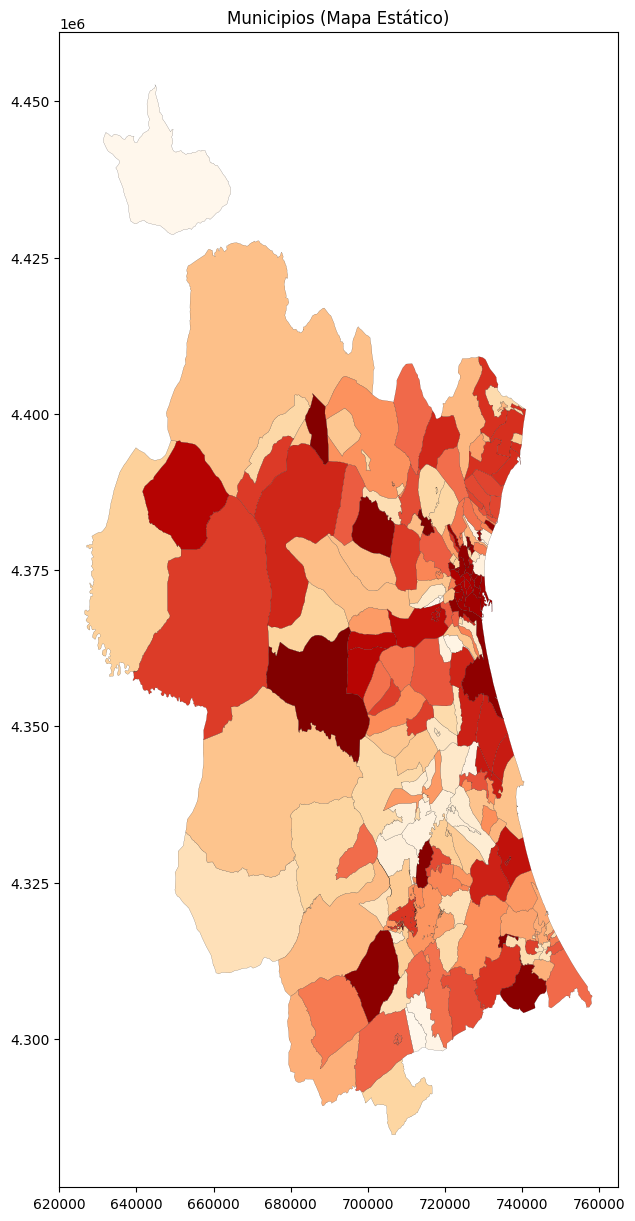

In [ ]:
import duckdb
import geopandas as gpd
import pandas as pd
from shapely import wkb



# 1. Extraemos los datos convirtiendo la geometría a WKB
# Nota: Filtramos por una provincia (ej. Madrid '28%') para no saturar el mapa al principio
query = """
    SELECT 
        id_districts,
        name_districts,

        ST_AsWKB(geometry) as geom_wkb
    FROM bronze.districts_info
    WHERE id_districts LIKE '46%'  -- Filtro para Madrid (opcional, quítalo para ver todo)
"""

df = con.sql(query).df()


# 2. Convertimos el DataFrame normal a GeoDataFrame
# Decodificamos el binario WKB a objetos geométricos reales
df['geometry'] = df['geom_wkb'].apply(lambda x: wkb.loads(bytes(x)))
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 3. Definir el Sistema de Referencia de Coordenadas (CRS)
# Los datos del MITMA suelen venir en ETRS89 (EPSG:4258)
gdf.set_crs(epsg=4258, inplace=True)

print(f"Cargados {len(gdf)} municipios.")
import matplotlib.pyplot as plt

# Visualización simple
fig, ax = plt.subplots(figsize=(10, 15))
gdf.plot(ax=ax, legend=True, cmap='OrRd', edgecolor='black', linewidth=0.1)
ax.set_title("Municipios (Mapa Estático)")
plt.show()

In [ ]:
os.makedirs('datalake/bronze/zonificacion', exist_ok=True)

In [ ]:
con.sql("""
    COPY bronze.municiples_info
    TO 'datalake/bronze/zonificacion/municiples.parquet' 
    (FORMAT PARQUET, COMPRESSION 'ZSTD', OVERWRITE_OR_IGNORE)
""")
con.sql("""
    COPY bronze.districts_info
    TO 'datalake/bronze/zonificacion/districts.parquet' 
    (FORMAT PARQUET, COMPRESSION 'ZSTD', OVERWRITE_OR_IGNORE)
con.sql("""
    COPY bronze.GAUS_info
    TO 'datalake/bronze/zonificacion/GAUS.parquet' 
    (FORMAT PARQUET, COMPRESSION 'ZSTD', OVERWRITE_OR_IGNORE)
""")

In [ ]:
def cargar_ine_mitma_zone_relation(con):
  file_info = con.sql(f"""
      SELECT source_url, filename 
      FROM bronze.catalog 
      WHERE (main_category = 'Zonificacion' OR main_category = 'Otros')
        AND (filename ILIKE '%relacion%') 
      
          
          """).df()
  file_info["source_url"][0]
  con.sql(f"""CREATE OR REPLACE TABLE bronze.INE_MITMA_zone_relation AS SELECT * FROM read_csv(
                  '{file_info["source_url"][0]}', 
                  delim='|', 
                  header=True, 
                  filename=True,       -- Fundamental para llenar source_url
                  union_by_name=True,  -- Robustez si cambia el orden de columnas
                  null_padding=True,
                  ignore_errors=True
              )""")

In [ ]:
con.sql("""
    COPY bronze.INE_MITMA_zone_relation
    TO 'datalake/bronze/zonificacion/INE_MITMA_zone_relation.parquet' 
    (FORMAT PARQUET, COMPRESSION 'ZSTD', OVERWRITE_OR_IGNORE)
""")

In [ ]:
con.close()

In [ ]:
con = duckdb.connect('movilidad_datalake.duckdb')
con.sql("INSTALL spatial; LOAD spatial;")

con.sql("DROP TABLE IF EXISTS bronze.catalog")
con.sql("""
    CREATE OR REPLACE VIEW bronze.catalog AS 
    SELECT * FROM parquet_scan('datalake/bronze/catalog/*.parquet')
""")


In [ ]:
con.sql("""

    SELECT * FROM bronze.catalog
""")

┌────────────────────┬────────────┬───────────┬────────┬────────┬────────┬─────────────────────┬────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│   main_category    │ study_type │ zone_type │  year  │ month  │  day   │  publication_date   │                filename                │                                                                 source_url                                                                  │
│      varchar       │  varchar   │  varchar  │ double │ double │ double │    timestamp_ns     │                varchar                 │                                                                   varchar                                                                   │
├────────────────────┼────────────┼───────────┼────────┼────────┼────────┼─────────────────────┼────────────────────────────────────────┼───────────────────────

In [ ]:
# A. Vista para el Catálogo


# B. Vista para Municipios (Recuperando geometría)
# Recuerda: Parquet guarda la geom como binario, hay que reconvertirla al leer
con.sql("""
    CREATE OR REPLACE VIEW bronze.municipios AS 
    SELECT 
        * EXCLUDE (geometria),
        ST_GeomFromWKB(geometria) as geometria
    FROM parquet_scan('datalake/bronze/zonificacion/*.parquet')
""")

# C. Vista para Viajes (Con detección automática de particiones)
# hive_partitioning=1 hace que DuckDB entienda que las carpetas son columnas (zone_type, year, month)
con.sql("""
    CREATE OR REPLACE VIEW bronze.viajes AS 
    SELECT * FROM parquet_scan('datalake/bronze/viajes/**/*.parquet', hive_partitioning=1)
""")

print("Vistas actualizadas. Ahora 'bronze.viajes' lee directamente de tus carpetas.")

# Prueba de fuego: Consultar usando las particiones físicas
print(con.sql("""
    SELECT zone_type, part_year, count(*) 
    FROM bronze.viajes 
    WHERE part_year = 2023 
    GROUP BY 1, 2
""").df())

In [ ]:
import duckdb
import geopandas as gpd
import folium
from shapely import wkb

con = duckdb.connect('movilidad_datalake.duckdb')
con.sql("INSTALL spatial; LOAD spatial;")

print("Ejecutando consulta analítica sobre el DuckLake...")

# Query optimizada que aprovecha tus particiones
query = """
    SELECT 
        m.id_municiples,
        m.name_municiples,
        sum(CAST(v.n_trips AS DOUBLE) )  as total_viajes_salida,
        ST_AsWKB(m.geometry) as geom_wkb
    FROM bronze.od_trips v
    -- Unimos con la tabla de geometrías
    JOIN bronze.municiples_info m ON v.id_origin = m.id_municiples
    WHERE 
        -- 1. Filtros de Partición (DuckDB solo abrirá la carpeta de Enero 2023)
        YEAR(v.date) = 2023 
        AND MONTH(v.date) = 1
        AND v.zone_type = 'Municipios'
        
        -- 2. Filtro de Negocio (Madrid = código 28)
        AND m.id_municiples LIKE '28%'
        
    GROUP BY m.id_municiples, m.name_municiples, m.geometry,

"""

# Convertimos el resultado a DataFrame de Pandas
df = con.sql(query).df()
con.close()

print(f"Datos recuperados: {len(df)} municipios de Madrid con datos de viajes.")
df.head(10)

Ejecutando consulta analítica sobre el DuckLake...
Datos recuperados: 119 municipios de Madrid con datos de viajes.


,id_municiples,name_municiples,total_viajes_salida,geom_wkb
0,28026,Brunete,72141.365,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 231, 0, 0, 0, 96, ..."
1,28028,Bustarviejo,6936.564,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 245, 0, 0, 0, 160,..."
2,28041,Cobeña,37337.439,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 154, 0, 0, 0, 192,..."
3,28066,Griñón,62267.013,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 105, 0, 0, 0, 128,..."
4,28104,Paracuellos de Jarama,159096.864,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 236, 0, 0, 0, 96, ..."
5,28110,Perales de Tajuña,8794.184,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 127, 0, 0, 0, 48, ..."
6,28113,Pinto,357881.532,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 215, 0, 0, 0, 48, ..."
7,28119,Quijorna,13631.613,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 18, 1, 0, 0, 64, 1..."
8,28129,San Agustín del Guadalix,64586.253,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 21, 1, 0, 0, 96, 2..."
9,28171,Villa del Prado,17683.859,"[1, 3, 0, 0, 0, 1, 0, 0, 0, 246, 0, 0, 0, 144,..."
